In [1]:
import sys, os
import numpy as np
import glob
import datetime
import json
import ipdb
import plotly.graph_objects as go
import random
import importlib
import cortex

import sys
sys.path.append("{}/../../../utils".format(os.getcwd()))
from pycortex_utils import set_pycortex_config_file
from surface_utils import make_surface_image , load_surface

In [2]:
# data filenames and folder
subject = 'sub-02'
rois = ['occ', 'par', 'frt']
grid_place = 0
no_bd = 1

#main_dir = '/Users/uriel/disks/meso_shared'
main_dir = '/home/mszinte/disks/meso_S/data/'
project_dir = 'RetinoMaps'
subject = 'sub-02'
gii_file = 'sub-02_task-pRF_hemi-L_fmriprep_dct_avg_bold.func.gii'

cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
data_path = '{}/{}/derivatives/pp_data/sub-02/prf/fit/test'.format(main_dir, project_dir)
input_fn_fsnative = '{}/{}/derivatives/pp_data/{}/func/fmriprep_dct_avg/fsnative/{}'.format(
    main_dir, project_dir, subject, gii_file)
prf_fit_test_dir = "{}/{}/derivatives/pp_data/{}/prf/fit/test".format(
    main_dir, project_dir, subject)

In [3]:
set_pycortex_config_file(cortex_dir)
importlib.reload(cortex)

<module 'cortex' from '/home/mszinte/env/anaconda3/envs/mszinte/lib/python3.9/site-packages/cortex/__init__.py'>

In [4]:
# load arrays
gauss_fit_mat_repeat = np.load(file='{}/{}_gauss_fit_mat_repeat.npy'.format(
    prf_fit_test_dir, subject))
gauss_pred_mat_repeat = np.load(file='{}/{}_gauss_pred_mat_repeat.npy'.format(
    prf_fit_test_dir, subject))
gauss_duration_repeat = np.load(file='{}/{}_gauss_duration_repeat.npy'.format(
    prf_fit_test_dir, subject))

# Load fsnative data 
data_img_fsnative, data_fsnative = load_surface(input_fn_fsnative)



In [5]:
roi_verts = cortex.get_roi_verts(subject=subject, 
                                 roi=rois, 
                                 mask=True)

In [6]:
# Get corresponding vertices
vert_mask_occ = roi_verts['occ']
vert_num_occ = np.sum(vert_mask_occ)
vert_mask_par = roi_verts['par']
vert_num_par = np.sum(vert_mask_par)
vert_mask_frt = roi_verts['frt']
vert_num_frt = np.sum(vert_mask_frt)

vert_mask = dict(occ=[0, vert_num_occ],
                 par=[vert_num_occ, vert_num_occ + vert_num_par],
                 frt=[vert_num_occ + vert_num_par, vert_num_occ + vert_num_par + vert_num_frt])


# number of repeat of fit
n_repeat = gauss_fit_mat_repeat.shape[2]-2

In [7]:
roi = 'occ'
df_roi = gauss_fit_mat_repeat[vert_mask[roi][0]:vert_mask[roi][1]:,:,:]

r2_mean = df_roi[:,-1,2:]
r2_mean =np.mean(df_roi[:,-1,2:],axis=0)
r2_grid_mean = np.mean(df_roi[:,-1,grid_place])
r2_bd_mean = np.mean(df_roi[:,-1,no_bd])

# Figure 1

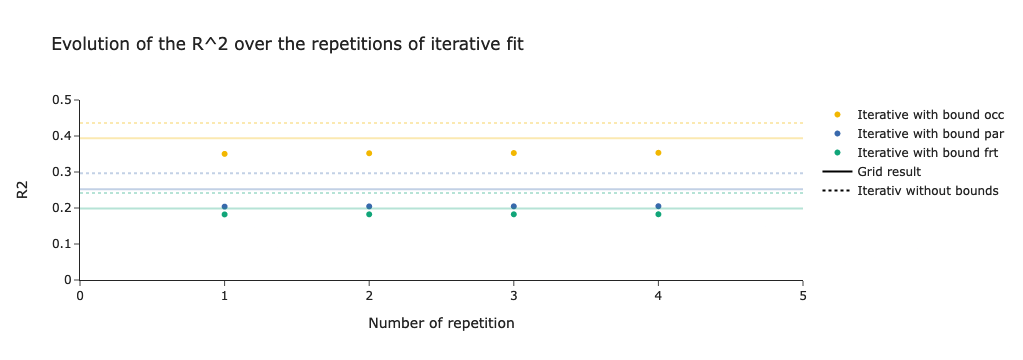

In [13]:
fig = go.Figure()
colors =['rgb(242, 183, 1)','rgb(57, 105, 172)','rgb(17, 165, 121)','rgb(127, 60, 141)']
for i , roi in enumerate(rois) :
    # select roi data 
    df_roi = gauss_fit_mat_repeat[vert_mask[roi][0]:vert_mask[roi][1]:,:,:]
    
    r2_mean =np.mean(df_roi[:,-1,2:],axis=0)
    r2_grid_mean = np.mean(df_roi[:,-1,grid_place])
    r2_bd_mean = np.mean(df_roi[:,-1,no_bd])
    
    # plot R2 roi
    fig.add_trace(go.Scatter(
        x=np.arange(0,n_repeat,1)+1,
        y=r2_mean,
        mode='markers',
        name='Iterative with bound {}'.format(roi),
        line_color=colors[i],
        showlegend=True))

    # plot r2 without bound
    fig.add_shape(
        type='line',
        x0=0, y0=r2_bd_mean, x1=n_repeat+1, y1=r2_bd_mean,
        line=dict(color=colors[i], width=2, dash='dot'),
        name='R2 without bound')

    # plot r2 grid
    fig.add_shape(
        type='line',
        x0=0, y0=r2_grid_mean, x1=n_repeat+1, y1=r2_grid_mean,
        line=dict(color=colors[i], width=2, dash='solid'), 
        name='R2 grid')
    
# for the legend
fig.add_trace(go.Scatter(x=[None],
                          y=[None],
                          mode='lines',
                          line=dict(color='black', width=2, dash='solid'),
                          name='Grid result'))

fig.add_trace(go.Scatter(x=[None],
                          y=[None],
                          mode='lines',
                          line=dict(color='black', width=2, dash='dot'),
                          name='Iterativ without bounds'))

fig.update_layout(template='simple_white',
                  title = 'Evolution of the R^2 over the repetitions of iterative fit',
                  xaxis_title = 'Number of repetition',
                  yaxis_title = 'R2'
                 )

fig.update_xaxes(range=[0,n_repeat+1])
fig.update_yaxes(range=[0,.5])
                 
fig.show()


# Figure 2

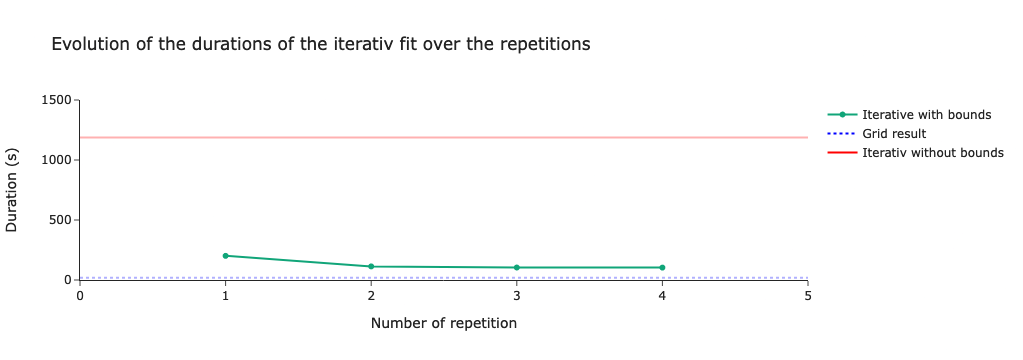

In [10]:
fig2 = go.Figure()

# plot duration iterativ repeat
fig2.add_trace(go.Scatter(
    x=np.arange(0,n_repeat,1)+1,
    y=gauss_duration_repeat[2:],
    mode='markers+lines',
    name='Iterative with bounds',
    line_color=colors[i],
    showlegend=True))

# plot duration grid 
fig2.add_shape(
    type='line',
    x0=0, y0=gauss_duration_repeat[0], x1=n_repeat+1, y1=gauss_duration_repeat[grid_place],
    line=dict(color='blue', width=2, dash='dot'), 
    name='grid')

# plot duration iterativ without bouns
fig2.add_shape(
    type='line',
    x0=0, y0=gauss_duration_repeat[1], x1=n_repeat+1, y1=gauss_duration_repeat[no_bd],
    line=dict(color='red', width=2, dash='solid'), 
    name='without bouns')

# for the legend
fig2.add_trace(go.Scatter(x=[None],
                          y=[None],
                          mode='lines',
                          line=dict(color='blue', width=2, dash='dot'),
                          name='Grid result'))

fig2.add_trace(go.Scatter(x=[None],
                          y=[None],
                          mode='lines',
                          line=dict(color='red', width=2, dash='solid'),
                          name='Iterativ without bounds'))

fig2.update_layout(template='simple_white',
                  title = 'Evolution of the durations of the iterativ fit over the repetitions',
                  xaxis_title = 'Number of repetition',
                  yaxis_title = 'Duration (s)')
fig2.update_xaxes(range=[0,n_repeat+1])
fig2.update_yaxes(range=[0,1500])

fig2.show()

# Figure 3

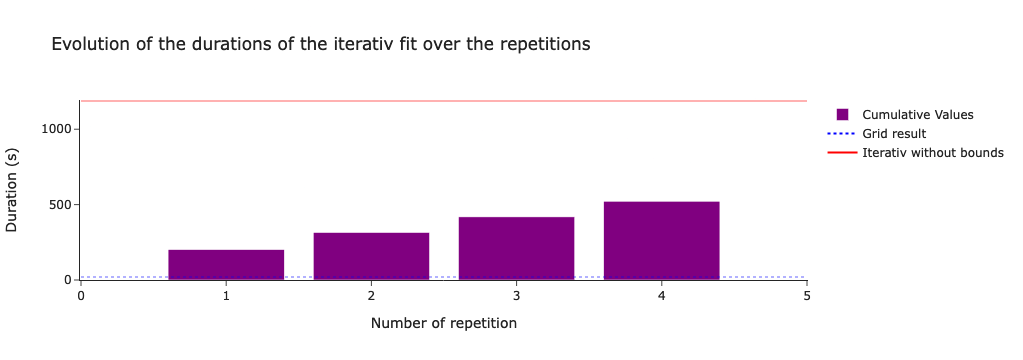

In [11]:
fig3 = go.Figure()
cumulative_durations = np.cumsum(gauss_duration_repeat[2:])
# plot duration iterativ repeat
fig3.add_trace(go.Bar(x=np.arange(0,n_repeat,1)+1,
                      y=cumulative_durations,
                      marker=dict(color='purple'),
                      name='Cumulative Values'))


# plot duration Iterativ without bounds 
fig3.add_shape(
    type='line',
    x0=0, y0=gauss_duration_repeat[grid_place], x1=n_repeat+1, y1=gauss_duration_repeat[grid_place],
    line=dict(color='blue', width=2, dash='dot'), 
    name='Grid result')

# plot duration grid 
fig3.add_shape(
    type='line',
    x0=0, y0=gauss_duration_repeat[no_bd], x1=n_repeat+1, y1=gauss_duration_repeat[no_bd],
    line=dict(color='red', width=2, dash='solid'), 
    name='Iterativ without bounds')

# for the legend
fig3.add_trace(go.Scatter(x=[None],
                          y=[None],
                          mode='lines',
                          line=dict(color='blue', width=2, dash='dot'),
                          name='Grid result'))

fig3.add_trace(go.Scatter(x=[None],
                          y=[None],
                          mode='lines',
                          line=dict(color='red', width=2, dash='solid'),
                          name='Iterativ without bounds'))


fig3.update_layout(template='simple_white',
                  title = 'Evolution of the durations of the iterativ fit over the repetitions',
                  xaxis_title = 'Number of repetition',
                  yaxis_title = 'Duration (s)')

fig2.update_xaxes(range=[0,n_repeat+1])
fig2.update_yaxes(range=[0,1500])

fig3.show()

# Figure 4

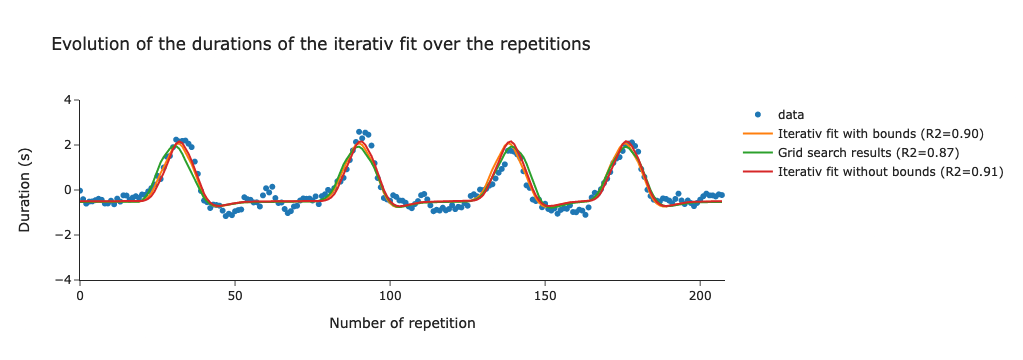

In [12]:
max_r2 = np.argmax(gauss_fit_mat_repeat[:,-1,-1])
num_vert = max_r2

fig4 = go.Figure()
# plot data time series
fig4.add_trace(go.Scatter(y=data_fsnative[:,num_vert],
                         name='data', 
                         mode='markers'))

# plot last iterativ repeat prediction
fig4.add_trace(go.Scatter(y=gauss_pred_mat_repeat[num_vert,:,-1],
                         name='Iterativ fit with bounds (R2={:1.2f})'.format(gauss_fit_mat_repeat[num_vert,-1,n_repeat])))

# plot grid prediction
fig4.add_trace(go.Scatter(y=gauss_pred_mat_repeat[num_vert,:,grid_place],
                         name='Grid search results (R2={:1.2f})'.format(gauss_fit_mat_repeat[num_vert,-1,grid_place])))

# plot Iterativ no bounds prediction
fig4.add_trace(go.Scatter(y=gauss_pred_mat_repeat[num_vert,:,no_bd],
                         name='Iterativ fit without bounds (R2={:1.2f})'.format(gauss_fit_mat_repeat[num_vert,-1,no_bd])))


fig4.update_layout(template='simple_white',
                  title = 'Evolution of the durations of the iterativ fit over the repetitions',
                  xaxis_title = 'Number of repetition',
                  yaxis_title = 'Duration (s)')
fig4.update_xaxes(range=[0,data_fsnative.shape[0]])
fig4.update_yaxes(range=[-4,4])

fig4.show()

In [ ]:
fig2.add_annotation(
    x=10,  # Modifier la position x selon votre graphique
    y=0.5,  # Modifier la position y selon votre graphique
    xref="x",
    yref="y",
    text="Solid line: grid<br>Dashed line: without bounds",
    showarrow=False,
    font=dict(
        size=12,
        color="black"
    )
)